In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import h5py
import numpy as np

%matplotlib inline

data['trial'][0] to access data
data['trial'][0].shape = 350  - these are the trials

In one trial:
data['trial'][0][x][0] - one number (60-68), session

data['trial'][0][x][1] - one number, stimAmp

data['trial'][0][x][2] - 'hit' or 'miss', response

data['trial'][0][x][3] - lick times

data['trial'][0][x][4] - (180,115) time*ca2+

In [2]:
def mat_to_h5py(filename, roi=False):
    print('Converting '+filename)
    data = loadmat(filename)
    f = h5py.File(filename+".hdf5", "w")
    if roi==False:
        n_trials = data['trial'][0].shape[0]
        experiment_number = data['trial'][0][0][0].shape[0]
        stim_strength = data['trial'][0][0][1].shape[0]
        hit_miss = data['trial'][0][0][2].shape[0]
        
        lick_times = 0                     #extract maximum number of lick times
        for i in range(n_trials):
            if data['trial'][0][i][3].shape[1] > lick_times:
                lick_times = data['trial'][0][i][3].shape[1]
        
        #print(lick_times)
        
        n_dendrites = data['trial'][0][0][4].shape[1]
        times = data['trial'][0][0][4].shape[0]
        
        print(n_dendrites, times)
        
        f.create_dataset("meta", (n_trials, experiment_number + stim_strength + hit_miss))
        if lick_times != 0:
            f.create_dataset("licktimes", (n_trials, lick_times)) # problem here
            f['licktimes'][:] = np.ones((n_trials, lick_times))*(-1)
        f.create_dataset("data", (n_trials, n_dendrites, times), dtype='float64')
        
        meta = np.zeros((n_trials, experiment_number + stim_strength + hit_miss))
        for i in range(n_trials):
            meta[i][0] = data['trial'][0][i][0][0][0] #experiment number
            meta[i][1] = data['trial'][0][i][1][0][0] #stim_strength
            if data['trial'][0][i][2][0]=='hit':
                meta[i][2] = 1    #hit/miss
            else:
                meta[i][2] = 0
        
        for i in range(n_trials):
            #f["meta"][i] = data['trial'][0][i][0][0][0]
            f['data'][i] = data['trial'][0][i][4].T
            #f['meta'][i][0] = data['trial'][0][i][0][0][0] #experiment number
            #f['meta'][i][1] = data['trial'][0][i][1][0][0] #stim_strength
            try:
                f['licktimes'][i,:data['trial'][0][i][3][0].shape[0]] = data['trial'][0][i][3][0]
            except IndexError:
                pass
        
        f['meta'][:] = meta

In [3]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

In [4]:
for filename in filelist:
    mat_to_h5py(filename)

Converting calcium_data/140708B_140811a_result
115 180
Converting calcium_data/140909C_141112a_result
101 180
Converting calcium_data/141006C_141121a_result
99 180
Converting calcium_data/150109A_150302a_result
84 180
Converting calcium_data/151122A_160202a_result
123 180
Converting calcium_data/151122B_160207a_result
135 180
Converting calcium_data/160209A_160430a_result
86 180
Converting calcium_data/160209B_160428a_result
91 180


In [4]:
filelist_roi = ["calcium_data/140708B_140811a_roi", 
            "calcium_data/140909C_141112a_roi", 
            "calcium_data/141006C_141121a_roi",
            "calcium_data/150109A_150302a_roi", 
            "calcium_data/151122A_160202a_roi", 
            "calcium_data/151122B_160207a_roi", 
            "calcium_data/160209A_160430a_roi", 
            "calcium_data/160209B_160428a_roi"]

In [5]:
def convert_roi(filename):
    print('Converting '+filename)
    data = loadmat(filename)
    f = h5py.File(filename+".hdf5", "w")
    
    roi = data['roi']
    driftMap = data['driftMap']
    roi_stay = data['roi_stay']
    inFrameDend = data['inFrameDend']
    
    f['roi'] = roi
    f['dirftMap'] = driftMap
    f['roi_stay'] = roi_stay
    f['inFrameDend'] = inFrameDend
    
    n_dendrites = data['dend'].shape[1]
    
    max_pix = 0
    for i in range(n_dendrites):
        pix = data['dend'][0][i][0].shape[0]
        if pix > max_pix:
            max_pix = pix
    dend = np.empty((n_dendrites, max_pix, 2))
    dend[:] = np.NAN
    for i in range(n_dendrites):
        lim = data['dend'][0][i][0].shape[0]
        dend[i,:lim,:] = data['dend'][0][i][0]
    f['dend'] = dend

In [6]:
for i in range(8):
    convert_roi(filelist_roi[i])

Converting calcium_data/140708B_140811a_roi
107
Converting calcium_data/140909C_141112a_roi
87
Converting calcium_data/141006C_141121a_roi
84
Converting calcium_data/150109A_150302a_roi
48
Converting calcium_data/151122A_160202a_roi
75
Converting calcium_data/151122B_160207a_roi
77
Converting calcium_data/160209A_160430a_roi
67
Converting calcium_data/160209B_160428a_roi
83


In [13]:
f = h5py.File(filelist_roi[0]+'.hdf5', 'r')
f['dend']

<HDF5 dataset "dend": shape (115, 107, 2), type "<f8">

In [29]:
f = h5py.File(filelist_roi[0]+'.hdf5', 'r')
f['inFrameDend'].shape

(115, 1)

In [28]:
g = h5py.File(filelist[0][:-6]+"roi.hdf5", 'r')
g['inFrameDend'][:].astype(bool)

array([[False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

In [14]:
f['meta'][3]

array([ 39.        ,   1.33333337,   1.        ], dtype=float32)

In [42]:
data = loadmat(filelist[1])
data['trial'][0][3][2]

array(['miss'], 
      dtype='<U4')

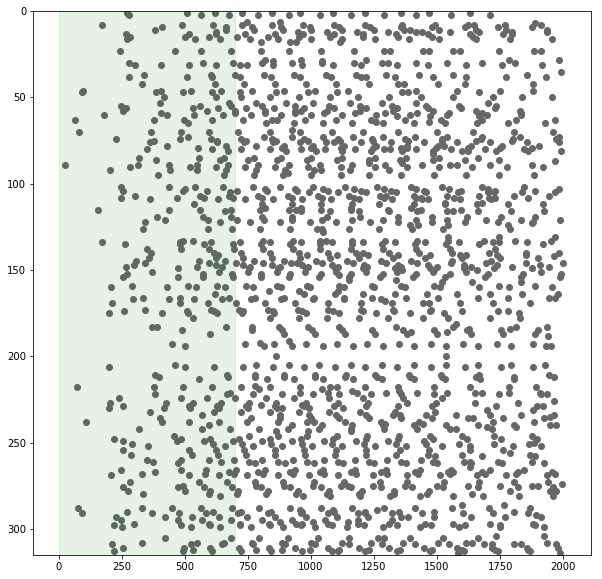

In [55]:
stim_list = []
for i in range(n_trials):
    stim_list.append(data['trial'][0][i][1][0][0])

sort = True
window = 700

n_trials = data['trial'][0].shape[0]

if sort:
    inds = np.argsort(stim_list)
else:
    inds = range(n_trials)

plt.figure(figsize=(10,10))
for i, k in enumerate(inds):
    d = "#5865D8"
    c = "#676768"
    
    try:
        valid_ltimes = data["trial"][0][i][3][0]
        plt.scatter(valid_ltimes, np.ones(len(data["trial"][0][i][3][0]))*k, color=c)
    except IndexError:
        pass
    #try:
    #    if valid_ltimes[0] <= window and f['meta'][i,2] == 1:                   #only mark blue if trial is a hit
    #        plt.scatter([valid_ltimes[0]], [k], color=d)                        #first lick is within window
    #except IndexError:
    #    pass

plt.axvspan(0, window, alpha=0.1, color='green')
    
plt.xlim=(-250,3000)
plt.ylim(0,n_trials)
plt.gca().invert_yaxis()

In [41]:
np.ones(len(data["trial"][0][0][3][0]))

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [37]:
data["trial"][0][1][3][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [3]:
data = loadmat("calcium_data/140708B_140811a_roi")

In [4]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'roi', 'driftMap', 'roi_stay', 'dend', 'inFrameDend'])

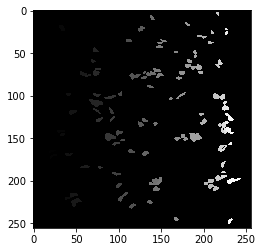

In [5]:
plt.imshow(data['roi'], cmap='gray')

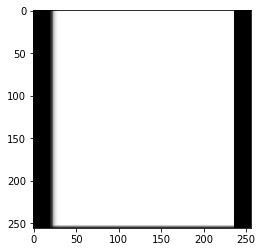

In [6]:
plt.imshow(data['driftMap'], cmap='gray')

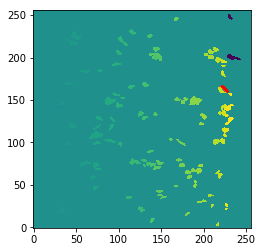

In [72]:
plt.imshow(data['roi_stay'], origin='lower')
plt.scatter(a[:,1], a[:,0], s=1, color='r')

In [71]:
a = data['dend'][0][97][0]

In [44]:
a.shape

(19, 2)

In [75]:
data['dend'].shape

(1, 115)